<a href="https://colab.research.google.com/github/samrakshanadhikari/Osteoporosis_diagnose_repo-/blob/main/RADIOGRAPHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("Using CPU only.")


CUDA available: False
Using CPU only.


Imports and setup

In [6]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Define paths and batch size

In [7]:
base_path = "/content/OP_Rolling_Ball_Imgs/OP_Rolling_Ball_Imgs"
batch_size = 32


Define transforms(with augmentation for train)

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # add vertical flip
    transforms.RandomRotation(30),    # increase rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [9]:
from google.colab import drive
drive. mount('/content/drive')


Mounted at /content/drive


In [10]:
!ls "/content/drive/My Drive"


 1678517359516-229a43c2-225d-4d52-9f46-3118f707e859.jpg
 academic.pdf
 adhikari.jpg
 Argue.gdoc
 BIMs_RiskLevels
'BIMs_RiskLevels (1)'
'CamScanner 01-05-2024 10.19_1 (1).pdf'
 Classic.gdoc
'Colab Notebooks'
'Copy of March 18 Conferences.gdoc'
'Copy of [Template] WEB101 Milestone #1 (1).gdoc'
'Copy of [Template] WEB101 Milestone #1.gdoc'
'Copy of WEB101 Prework Submission [Template] (1).gdoc'
'Copy of WEB101 Prework Submission [Template].gdoc'
 cv.jpg
 EarthEngine
'EE 2420 LABORATORY REPORT 03.gdoc'
'EE 2420 LABORATORY REPORT 03.pdf'
'Experiment 2 - Constant Acceleration.gdoc'
'Experiment 2 - Constant Acceleration.pdf'
'Experiment 3 Backward Acceleration Gaurab (1).pdf.gdoc'
'Experiment 3 Backward Acceleration Gaurab.pdf.gdoc'
'Fall 2024 Blank Availability_copy.pdf'
'Gaurab Shrestha Outline.docx'
'grade 11 gradesheet.pdf'
'IA Application QR Code (1).png.gdoc'
'IA Application QR Code.png.gdoc'
 iLovePDF
 ilovepdf_merged.gdoc
 ilovepdf_merged.pdf
 IMG_20230324_161157.jpg
 IMG-20230324-WA0

In [20]:
!ls "/content/drive/My Drive/OP_Rolling_Ball_Imgs"


C1  C3


In [11]:
from torchvision import datasets
full_dataset = datasets.ImageFolder(data_dir)
print(full_dataset.class_to_idx)
print(f"Total images: {len(full_dataset)}")


{'C1': 0, 'C3': 1}
Total images: 775


laod datset and split

In [12]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import torch

data_dir = "/content/drive/My Drive/OP_Rolling_Ball_Imgs"  # adjust path if needed

# Load full dataset without transforms to get total size and indices
full_dataset = datasets.ImageFolder(data_dir)
total_size = len(full_dataset)
indices = list(range(total_size))

# Split dataset indices: 70% train, 15% val, 15% test
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# Create subsets with respective transforms
train_dataset = Subset(datasets.ImageFolder(data_dir, transform=train_transform), train_indices)
val_dataset = Subset(datasets.ImageFolder(data_dir, transform=val_test_transform), val_indices)
test_dataset = Subset(datasets.ImageFolder(data_dir, transform=val_test_transform), test_indices)

# DataLoader parameters
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 17
Validation batches: 4
Test batches: 4


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import UnidentifiedImageError

# Custom ImageFolder to skip corrupted images gracefully
class CleanImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except UnidentifiedImageError:
            # Skip corrupted image by getting next index modulo dataset length
            return self.__getitem__((index + 1) % len(self))

# Normalization stats for ImageNet pretrained models
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training data transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Validation and Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Load full dataset once without transforms
data_dir = "/content/drive/My Drive/OP_Rolling_Ball_Imgs"
full_dataset = CleanImageFolder(data_dir, transform=None)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Random split
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

# Now set transforms for each subset separately
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

# DataLoader parameters
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet-18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace classifier head for 2 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

# Loss and optimizer with L2 regularization (weight_decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


Train samples: 542
Validation samples: 116
Test samples: 117
Using device: cpu
Epoch 1/10
  Train Loss: 0.5461, Train Acc: 0.7196
  Val   Loss: 0.6122, Val   Acc: 0.7328
Epoch 2/10
  Train Loss: 0.0827, Train Acc: 0.9852
  Val   Loss: 0.3269, Val   Acc: 0.8879
Epoch 3/10
  Train Loss: 0.0211, Train Acc: 0.9982
  Val   Loss: 0.3173, Val   Acc: 0.8879
Epoch 4/10
  Train Loss: 0.0097, Train Acc: 1.0000
  Val   Loss: 0.3495, Val   Acc: 0.8879
Epoch 5/10
  Train Loss: 0.0060, Train Acc: 1.0000
  Val   Loss: 0.4062, Val   Acc: 0.9052
Epoch 6/10
  Train Loss: 0.0023, Train Acc: 1.0000
  Val   Loss: 0.3607, Val   Acc: 0.8879
Epoch 7/10
  Train Loss: 0.0055, Train Acc: 1.0000
  Val   Loss: 0.3532, Val   Acc: 0.8966
Epoch 8/10
  Train Loss: 0.0023, Train Acc: 1.0000
  Val   Loss: 0.4059, Val   Acc: 0.9052
Epoch 9/10
  Train Loss: 0.0013, Train Acc: 1.0000
  Val   Loss: 0.3626, Val   Acc: 0.8966
Epoch 10/10
  Train Loss: 0.0014, Train Acc: 1.0000
  Val   Loss: 0.3387, Val   Acc: 0.8879


In [15]:
def evaluate(model, dataloader, criterion=None, device=torch.device("cpu"), name="Test"):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total if criterion is not None else None
    accuracy = correct / total

    if avg_loss is not None:
        print(f"{name} Loss: {avg_loss:.4f}, {name} Accuracy: {accuracy:.4f}")
    else:
        print(f"{name} Accuracy: {accuracy:.4f}")

    return accuracy

# After your training loop finishes, call:
test_acc = evaluate(model, test_loader, criterion, device, name="Test")


Test Loss: 0.3997, Test Accuracy: 0.8889


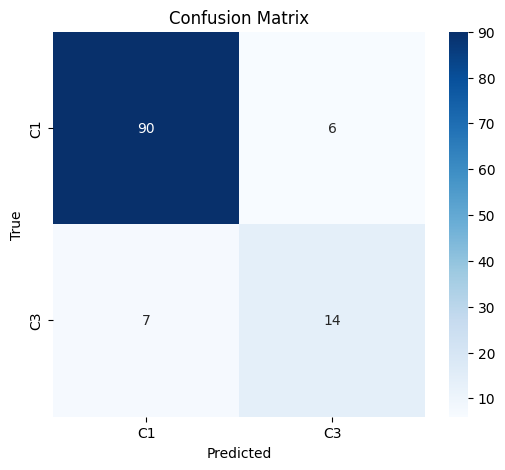

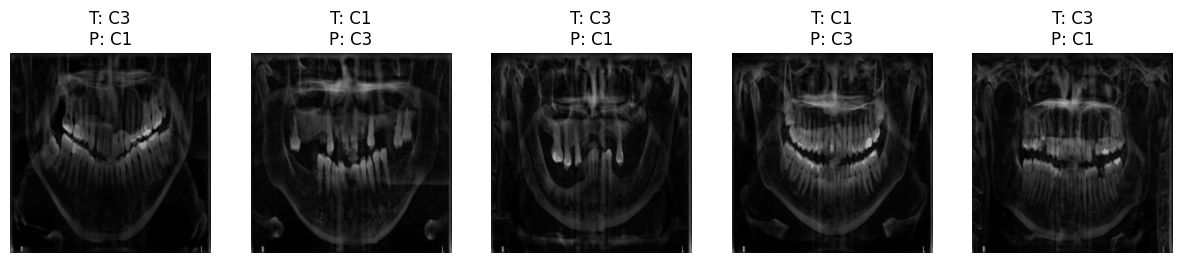

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Return preds and labels to help with misclassified images
    return all_preds, all_labels

def show_misclassified_images(model, dataloader, device, dataset, preds, labels, class_names, max_images=5):
    misclassified_indices = [i for i, (p, t) in enumerate(zip(preds, labels)) if p != t]

    import torchvision.transforms.functional as TF

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(misclassified_indices[:max_images]):
        img, true_label = dataset[idx]
        pred_label = class_names[preds[idx]]
        true_label_name = class_names[labels[idx]]

        # Undo normalization for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img.numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax = plt.subplot(1, max_images, i+1)
        ax.imshow(img)
        ax.set_title(f"T: {true_label_name}\nP: {pred_label}")
        ax.axis('off')
    plt.show()

# Plot confusion matrix and get predictions
all_preds, all_labels = plot_confusion_matrix(model, test_loader, device, full_dataset.classes)

# Show some misclassified images
show_misclassified_images(model, test_loader, device, test_ds.dataset, all_preds, all_labels, full_dataset.classes)
